# Projeto de Aprendizagem de Máquina

## *Partitioning fuzzy K-medoids clustering algorithms with relevance weight for each dissimilarity matrix estimated locally*

In [1]:
import pandas as pd
import numpy as np
import os
from tqdm import tqdm

from scipy.spatial.distance import pdist, squareform

from sklearn.preprocessing import MinMaxScaler
from scipy import stats

from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.base import clone

from sklearn.neighbors import KernelDensity
from scipy.stats import gaussian_kde
from sklearn.base import BaseEstimator, ClassifierMixin

import matplotlib.pyplot as plt
import seaborn as sns

### Leitura dos dados

In [2]:
PATH = '../data/'

In [3]:
view1 = pd.read_csv(os.path.join(PATH, 'mfeat-fac'), sep='\s+', header=None)
view2 = pd.read_csv(os.path.join(PATH, 'mfeat-fou'), sep='\s+',  header=None)
view3 = pd.read_csv(os.path.join(PATH, 'mfeat-kar'), sep='\s+',  header=None)

In [47]:
print(view1.shape)
print(view2.shape)
print(view3.shape)

(2000, 216)
(2000, 76)
(2000, 64)


### Obter target

In [11]:
y = pd.read_csv('../clustering/results_multiviews/particao_crisp.csv', header=None, squeeze=True)

### Pré-processamento

#### Normalização (reescala)

In [12]:
scaler = MinMaxScaler()
view1 = scaler.fit_transform(view1)

scaler = MinMaxScaler()
view2 = scaler.fit_transform(view2)

scaler = MinMaxScaler()
view3 = scaler.fit_transform(view3)

## Classificação

### Valicação cruzada com regra da soma

In [14]:
def fit(model, Xs, y):
    n_datasets = len(Xs)
    estimators = [clone(model) for _ in range(n_datasets)]
    
    for i in range(n_datasets):
        estimators[i].fit(Xs[i], y)
        
    return estimators

In [15]:
def predict(estimators, Xs):
    predictions = []
    
    n_datasets = len(Xs)
    
    for i in range(n_datasets):
        pred = estimators[i].predict_proba(Xs[i])
        predictions.append(pred)
        
    predictions = np.array(predictions)
    
    predictions = np.sum(predictions, axis=0)
    
    predictions = np.argmax(predictions, axis=1)
    
    return predictions

In [16]:
def fine_tuning(model, parameters, Xs_train, y_train, Xs_val, y_val, verbose=0):
    if verbose > 0:
        print('###########')
    
    n_datasets = len(Xs_train)
    
    results = []
    for key, values in parameters.items():
        for value in values:
            clf = model(**{key: value})
    
            estimators = fit(clf, Xs_train, y_train)
            pred = predict(estimators, Xs_val)

            result = accuracy_score(y_val, pred)
            results.append({key: value, 'acurácia': result})

    results_df = pd.DataFrame(results)
    
    best_result = results_df.sort_values('acurácia', ascending=False).iloc[0]
    best_params = best_result[list(parameters.keys())].convert_dtypes().to_dict()
    
    
    if verbose > 0:
        print('Resultados: ')
        print(results_df)
        print('Melhor resultado:')
        print(best_result['acurácia'])
        print('Melhores parâmetros:')
        print(best_params)

    return best_params

In [20]:
def cross_val(model, parameters=None, verbose=0):
    predictions = []
    targets = []
    results = []
    kfold = StratifiedKFold(n_splits=10, shuffle=True)
    for train, test in kfold.split(y.index, y):
        
        best_param = None
        
        if parameters:
            ## Tuning
            
            train_aux, val = train_test_split(train, test_size=0.222)

            y_train = y[train_aux]
            y_val = y[val]

            view1_train = view1[train_aux]
            view2_train = view2[train_aux]
            view3_train = view3[train_aux]

            view1_val = view1[val]
            view2_val = view2[val]
            view3_val = view3[val]

            Xs_train = [view1_train, view2_train, view3_train]
            Xs_val = [view1_val, view2_val, view3_val]
            best_param = fine_tuning(KNeighborsClassifier, parameters, Xs_train, y_train, Xs_val, y_val, verbose)
        
        ## Validation
        y_train = y[train]
        y_test = y[test]

        view1_train = view1[train]
        view2_train = view2[train]
        view3_train = view3[train]

        view1_test = view1[test]
        view2_test = view2[test]
        view3_test = view3[test]
        
        Xs_train = [view1_train, view2_train, view3_train]
        Xs_test = [view1_test, view2_test, view3_test]
        
        if best_param:
            clf = model(**best_param)
        else:
            clf = model()
        
        estimators = fit(clf, Xs_train, y_train)
        pred = predict(estimators, Xs_test)
        
        predictions.extend(pred)
        targets.extend(y_test.values)
        

    results = accuracy_score(targets, predictions)
        
    return results

### Parzen Window

### Implementação da predição com janela de parzen

In [22]:
class KDEClassifier(BaseEstimator, ClassifierMixin):
    """Bayesian generative classification based on KDE
    
    Parameters
    ----------
    bandwidth : float
        the kernel bandwidth within each class
    kernel : str
        the kernel name, passed to KernelDensity
    """
    def __init__(self, bandwidth=1.0, kernel='gaussian'):
        self.bandwidth = bandwidth
        self.kernel = kernel
        
    def fit(self, X, y):
        self.classes_ = np.sort(np.unique(y))
        training_sets = [X[y == yi] for yi in self.classes_]
        self.models_ = [KernelDensity(bandwidth=self.bandwidth,
                                      kernel=self.kernel).fit(Xi)
                        for Xi in training_sets]
        self.logpriors_ = [np.log(Xi.shape[0] / X.shape[0])
                           for Xi in training_sets]
        return self
        
    def predict_proba(self, X):
        logprobs = np.array([model.score_samples(X)
                             for model in self.models_]).T
        result = np.exp(logprobs + self.logpriors_)
        return result / result.sum(1, keepdims=True)
        
    def predict(self, X):
        return self.classes_[np.argmax(self.predict_proba(X), 1)]

### Experimentos

In [23]:
n_experiments = 30

### Naive Bayes

In [24]:
model = GaussianNB

results_nb = []
for i in tqdm(range(n_experiments)):
    result = cross_val(model)
    results_nb.append(result)
results_nb

100%|██████████| 30/30 [00:04<00:00,  7.11it/s]


[0.7005,
 0.707,
 0.705,
 0.6995,
 0.7025,
 0.7035,
 0.7015,
 0.7005,
 0.704,
 0.704,
 0.7035,
 0.703,
 0.704,
 0.706,
 0.7045,
 0.707,
 0.702,
 0.7035,
 0.7035,
 0.7035,
 0.703,
 0.704,
 0.7025,
 0.703,
 0.7025,
 0.702,
 0.704,
 0.7015,
 0.703,
 0.7045]

### k-NN

In [25]:
parameters = {'n_neighbors': [1, 3, 5, 7, 9]}
model = KNeighborsClassifier

results_knn = []
for i in tqdm(range(n_experiments)):
    result = cross_val(model, parameters)
    results_knn.append(result)
results_knn

100%|██████████| 30/30 [07:55<00:00, 15.84s/it]


[0.7585,
 0.7525,
 0.7565,
 0.757,
 0.7485,
 0.754,
 0.7575,
 0.755,
 0.756,
 0.7525,
 0.7525,
 0.7525,
 0.7585,
 0.751,
 0.7545,
 0.7615,
 0.7555,
 0.7585,
 0.7565,
 0.7585,
 0.755,
 0.7545,
 0.7605,
 0.759,
 0.756,
 0.7585,
 0.7525,
 0.759,
 0.7605,
 0.7505]

### Janela de Parzen

In [26]:
parameters = {'bandwidth': [0.1, 0.3, 0.5, 1, 1.5, 2]}
model = KDEClassifier

results_parzen = []
for i in tqdm(range(n_experiments)):
    result = cross_val(model)
    results_parzen.append(result)
results_parzen

100%|██████████| 30/30 [01:22<00:00,  2.74s/it]


[0.674,
 0.674,
 0.6745,
 0.6755,
 0.6735,
 0.675,
 0.673,
 0.675,
 0.6775,
 0.6745,
 0.674,
 0.674,
 0.674,
 0.6725,
 0.678,
 0.6735,
 0.676,
 0.674,
 0.6755,
 0.673,
 0.674,
 0.6755,
 0.676,
 0.674,
 0.6765,
 0.674,
 0.675,
 0.673,
 0.674,
 0.6735]

### Box plot

In [27]:
results_df = pd.DataFrame(np.vstack((results_nb, results_knn, results_parzen)).T, columns=['Naive Bayes', 'k-NN', 'Parzen'])

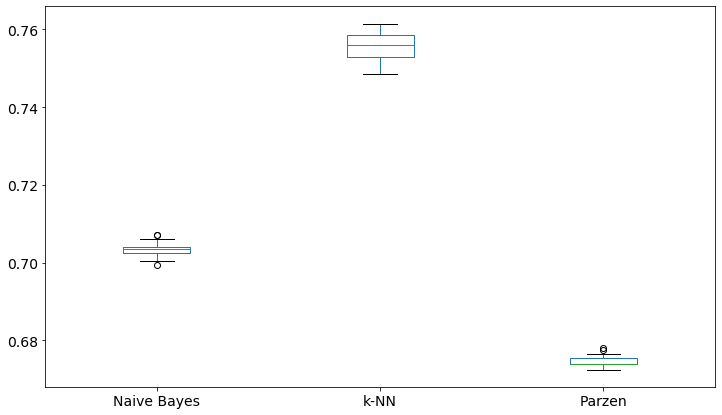

In [28]:
results_df.boxplot(figsize=(12,7), grid=False, fontsize=14)

### Friedman test

In [30]:
stat, p = stats.friedmanchisquare(results_nb, results_knn, results_parzen)

In [31]:
print('Statistics=%.3f, p=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
    print('Distribuições iguais (falha em rejeitar H0)')
else:
    print('Distribuições diferentes (rejeita H0)')

Statistics=60.000, p=0.000
Distribuições diferentes (rejeita H0)


### Intervalo de confiança

In [32]:
def normality_test(sample, sample_name):
    stat, p = stats.shapiro(sample)
    alpha = 0.05
    if p > alpha:
        print(sample_name + ': segue a distribuição normal (falha em rejeitar H0)')
    else:
        print(sample_name + ' Não segue a distribuição normal (rejeita H0)')

In [36]:
normality_test(results_nb, 'NB')
normality_test(results_knn, 'k-NN')
normality_test(results_parzen, 'Parzen')

NB: segue a distribuição normal (falha em rejeitar H0)
k-NN: segue a distribuição normal (falha em rejeitar H0)
Parzen Não segue a distribuição normal (rejeita H0)


In [45]:
def mean_confidence_interval(results, sample_name):
    confidence_level = 0.95
    degrees_freedom = len(results) - 1
    sample_mean = np.mean(results)
    sample_standard_error = stats.sem(results)

    confidence_interval = stats.t.interval(confidence_level, degrees_freedom, sample_mean, sample_standard_error)

    print('### {} ###'.format(sample_name))
    print('Estimativa pontual:', sample_mean)
    print('Intervalo de confiaça:', confidence_interval)
    print('Confiança de {}%'.format(int(confidence_level*100)))
    print('\n')

In [46]:
mean_confidence_interval(results_nb, 'NB')
mean_confidence_interval(results_knn, 'k-NN')
mean_confidence_interval(results_parzen, 'Parzen')

### NB ###
Estimativa pontual: 0.7032833333333333
Intervalo de confiaça: (0.7026427686183639, 0.7039238980483026)
Confiança de 95%


### k-NN ###
Estimativa pontual: 0.7557833333333334
Intervalo de confiaça: (0.7545706964375075, 0.7569959702291592)
Confiança de 95%


### Parzen ###
Estimativa pontual: 0.6745500000000001
Intervalo de confiaça: (0.6740612898150281, 0.6750387101849721)
Confiança de 95%


